In [1]:
%load_ext autoreload
%autoreload 2

In [128]:
from dataclasses import dataclass

import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader
from mamba import S4_naive,S4_fast,S4_with_shared_A,MultiChannelS4, MambaBlock, Mamba

In [3]:
@dataclass
class DataCfg:
    D: int = 4
    L: int = 256
    n_train: int = 4096
    n_val: int = 512
    noise_std: float = 0.2
    f_low: float = 0.5
    f_high: float = 6.0
    amp_low: float = 0.5
    amp_high: float = 1.5

class SineDenoise(Dataset):
    def __init__(self, cfg: DataCfg, split: str = "train", seed: int = 0):
        self.cfg = cfg
        self.split = split
        rng = random.Random(seed)
        self.size = cfg.n_train if split == "train" else cfg.n_val
        self.params = []
        for _ in range(self.size):
            # per-sample params per channel
            freqs = [rng.uniform(cfg.f_low, cfg.f_high) for _ in range(cfg.D)]
            phases = [rng.uniform(0, 2*math.pi) for _ in range(cfg.D)]
            amps = [rng.uniform(cfg.amp_low, cfg.amp_high) for _ in range(cfg.D)]
            self.params.append((freqs, phases, amps))

        # fixed time grid
        self.t = torch.linspace(0, 1, cfg.L)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        D, L = self.cfg.D, self.cfg.L
        freqs, phases, amps = self.params[idx]
        clean = torch.empty(D, L)
        for d in range(D):
            clean[d] = amps[d] * torch.sin(2*math.pi*freqs[d]*self.t + phases[d])
        noisy = clean + self.cfg.noise_std * torch.randn_like(clean)
        # Input: noisy (D,L); Target: clean (D,L)
        return noisy, clean

In [5]:
#Train/eval
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64 #paper 265
    L: int = 256
    epochs: int = 100
    batch_size: int = 64
    lr: float = 1e-3
    use_hippo: bool = True
    mode: str = "Conv_fft"
    implementation: str = "fast"
    rank: int = 2
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123

def train_demo():
    # Seeds
    torch.manual_seed(TrainCfg.seed)

    # Data
    dcfg = DataCfg(D=TrainCfg.n_channels, L=TrainCfg.L)
    train_ds = SineDenoise(dcfg, "train", seed=0)
    val_ds = SineDenoise(dcfg, "val", seed=1)
    train_loader = DataLoader(train_ds, batch_size=TrainCfg.batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=TrainCfg.batch_size, shuffle=False)

    # Model
    model = MultiChannelS4(
        n_channels=TrainCfg.n_channels,
        hidden_state=TrainCfg.N,
        kernel_max_size=TrainCfg.L,
        min_delta=1e-3,
        max_delta=1e-1,
        mode=TrainCfg.mode,
        seed=42,
        implementation=TrainCfg.implementation,
        use_hippo=TrainCfg.use_hippo,
        rank=TrainCfg.rank,
    ).to(TrainCfg.device)

    opt = torch.optim.Adam(model.parameters(), lr=TrainCfg.lr)
    best_val = float("inf")
    train_losses, val_losses = [], []

    def run_loader(loader, train: bool):
        tot, n = 0.0, 0
        if train:
            model.train()
        else:
            model.eval()
        for noisy, clean in loader:
            noisy = noisy.to(TrainCfg.device)   # (B,D,L)
            clean = clean.to(TrainCfg.device)   # (B,D,L)
            if train:
                opt.zero_grad(set_to_none=True)
            pred = model(noisy)                 # (B,D,L)
            loss = nn.functional.mse_loss(pred, clean)
            if train:
                loss.backward()
                opt.step()
            tot += loss.item() * noisy.size(0)
            n += noisy.size(0)
        return tot / max(n, 1)

    print("Starting training...")
    t0 = time.time()
    for epoch in range(1, TrainCfg.epochs + 1):
        tr = run_loader(train_loader, train=True)
        va = run_loader(val_loader, train=False)
        train_losses.append(tr)
        val_losses.append(va)
        if va < best_val:
            best_val = va
            torch.save(
                {"model_state": model.state_dict(), "cfg": (TrainCfg, DataCfg)},
                "./models/S4_Multi/mcs4_demo.pt",
            )
        print(f"Epoch {epoch:02d}/{TrainCfg.epochs}  train {tr:.4f}  val {va:.4f}")
    print(f"Done in {time.time()-t0:.1f}s. Best val {best_val:.4f}")

    # ---- Visualization
    # Loss curves
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training curves (denoising)")
    plt.legend()
    plt.show()

    # Qualitative predictions on a random validation batch & a single channel
    model.eval()
    with torch.no_grad():
        noisy, clean = next(iter(val_loader))
        noisy = noisy.to(TrainCfg.device)
        clean = clean.to(TrainCfg.device)
        pred = model(noisy)

    b = 0               # first sample in batch
    d = 0               # channel 0
    x = noisy[b, d].detach().cpu()
    y = clean[b, d].detach().cpu()
    yhat = pred[b, d].detach().cpu()

    plt.figure()
    plt.plot(x, label="noisy input")
    plt.plot(y, label="clean target")
    plt.plot(yhat, label="model output")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Denoising example (one sample, one channel)")
    plt.legend()
    plt.show()


In [65]:
torch.manual_seed(TrainCfg.seed)
D=1
N=3
L=5
    # Data
dcfg = DataCfg(D=D, L=L)
train_ds = SineDenoise(dcfg, "train", seed=0)
val_ds = SineDenoise(dcfg, "val", seed=1)
train_loader = DataLoader(train_ds, batch_size=TrainCfg.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=TrainCfg.batch_size, shuffle=False)

# Model
model = MultiChannelS4(
    n_channels=D,
    hidden_state=N,
    kernel_max_size=L,
    min_delta=1e-3,
    max_delta=1e-1,
    mode="Conv_FFT",
    implementation="fast",
    seed=42,
    rank=2
).to(TrainCfg.device)


Starting training...
Epoch 01/10  train 0.0432  val 0.0365
Epoch 02/10  train 0.0325  val 0.0286
Epoch 03/10  train 0.0253  val 0.0222
Epoch 04/10  train 0.0198  val 0.0178
Epoch 05/10  train 0.0165  val 0.0155
Epoch 06/10  train 0.0148  val 0.0144
Epoch 07/10  train 0.0141  val 0.0140
Epoch 08/10  train 0.0137  val 0.0136
Epoch 09/10  train 0.0135  val 0.0135
Epoch 10/10  train 0.0134  val 0.0134
Done in 84.0s. Best val 0.0134


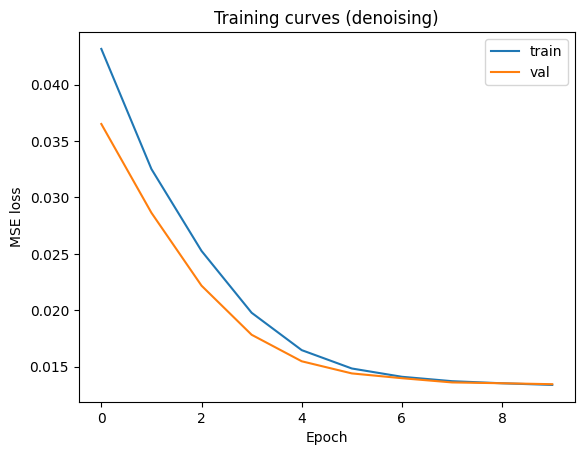

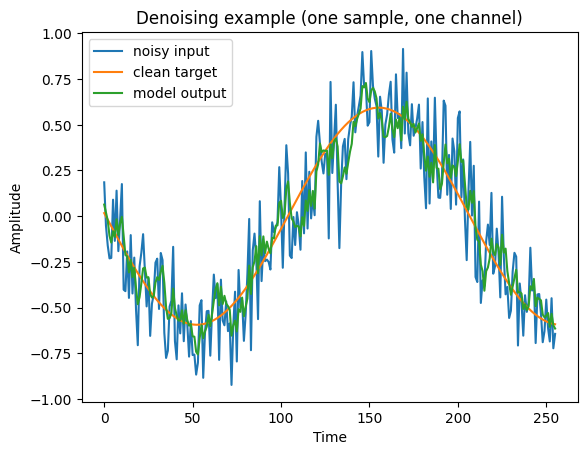

In [67]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 10
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "naive"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank=2
    
%timeit
train_demo()

Starting training...
Epoch 01/20  train 0.0380  val 0.0351
Epoch 02/20  train 0.0333  val 0.0317
Epoch 03/20  train 0.0299  val 0.0283
Epoch 04/20  train 0.0266  val 0.0251
Epoch 05/20  train 0.0234  val 0.0220
Epoch 06/20  train 0.0206  val 0.0194
Epoch 07/20  train 0.0184  val 0.0176
Epoch 08/20  train 0.0170  val 0.0166
Epoch 09/20  train 0.0162  val 0.0160
Epoch 10/20  train 0.0157  val 0.0156
Epoch 11/20  train 0.0154  val 0.0154
Epoch 12/20  train 0.0153  val 0.0152
Epoch 13/20  train 0.0151  val 0.0151
Epoch 14/20  train 0.0149  val 0.0149
Epoch 15/20  train 0.0148  val 0.0148
Epoch 16/20  train 0.0147  val 0.0146
Epoch 17/20  train 0.0145  val 0.0145
Epoch 18/20  train 0.0144  val 0.0144
Epoch 19/20  train 0.0143  val 0.0142
Epoch 20/20  train 0.0142  val 0.0142
Done in 73.8s. Best val 0.0142


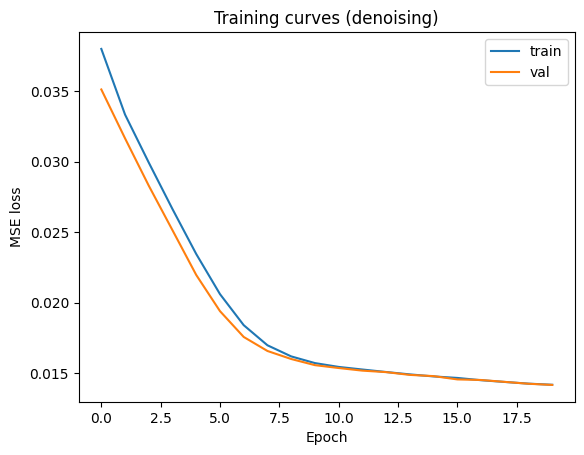

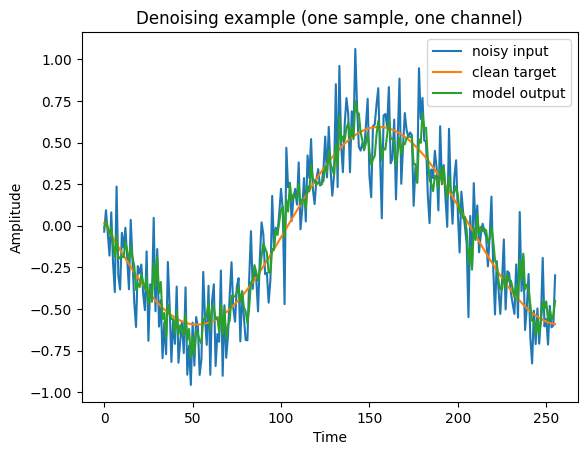

In [68]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 20
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "fast"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank: int =2
    
%timeit
train_demo()

Starting training...
Epoch 01/10  train 0.0402  val 0.0360
Epoch 02/10  train 0.0334  val 0.0311
Epoch 03/10  train 0.0295  val 0.0280
Epoch 04/10  train 0.0267  val 0.0255
Epoch 05/10  train 0.0241  val 0.0229
Epoch 06/10  train 0.0218  val 0.0207
Epoch 07/10  train 0.0197  val 0.0189
Epoch 08/10  train 0.0181  val 0.0176
Epoch 09/10  train 0.0170  val 0.0167
Epoch 10/10  train 0.0163  val 0.0161
Done in 28.8s. Best val 0.0161


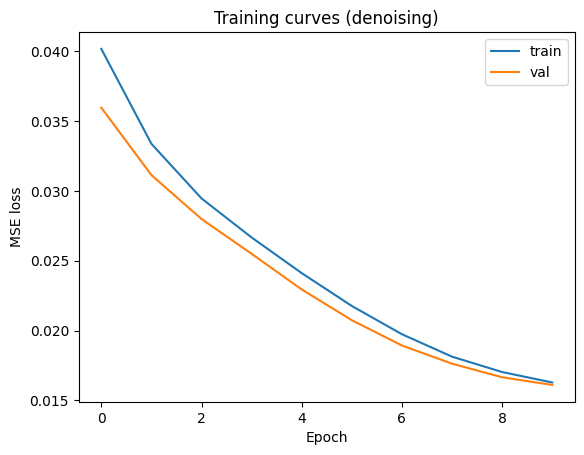

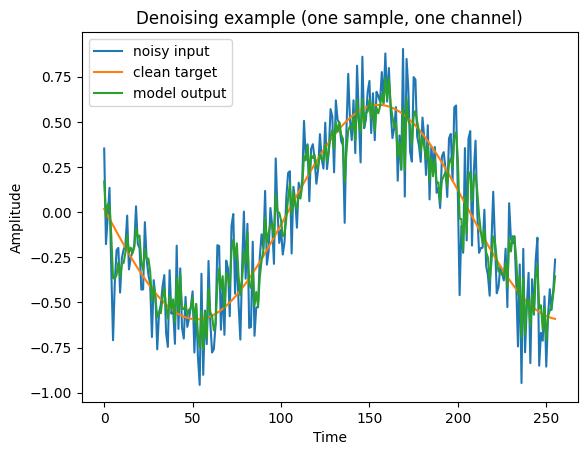

In [6]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 10
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "fast"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank: int =1
    
%timeit
train_demo()

In [ ]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 10
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN"
    implementation:str = "fast"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank: int =1
    
%timeit
train_demo()

Starting training...
Epoch 01/100  train 0.2651  val 0.0874
Epoch 02/100  train 0.0569  val 0.0447
Epoch 03/100  train 0.0432  val 0.0422
Epoch 04/100  train 0.0414  val 0.0408
Epoch 05/100  train 0.0400  val 0.0394
Epoch 06/100  train 0.0390  val 0.0386
Epoch 07/100  train 0.0383  val 0.0380
Epoch 08/100  train 0.0378  val 0.0378
Epoch 09/100  train 0.0376  val 0.0374
Epoch 10/100  train 0.0374  val 0.0373
Epoch 11/100  train 0.0373  val 0.0374
Epoch 12/100  train 0.0373  val 0.0372
Epoch 13/100  train 0.0373  val 0.0374
Epoch 14/100  train 0.0372  val 0.0372
Epoch 15/100  train 0.0373  val 0.0373
Epoch 16/100  train 0.0373  val 0.0372
Epoch 17/100  train 0.0372  val 0.0372
Epoch 18/100  train 0.0373  val 0.0372
Epoch 19/100  train 0.0373  val 0.0372
Epoch 20/100  train 0.0373  val 0.0372
Epoch 21/100  train 0.0372  val 0.0371
Epoch 22/100  train 0.0372  val 0.0371
Epoch 23/100  train 0.0373  val 0.0371
Epoch 24/100  train 0.0372  val 0.0373
Epoch 25/100  train 0.0373  val 0.0373
Epoc

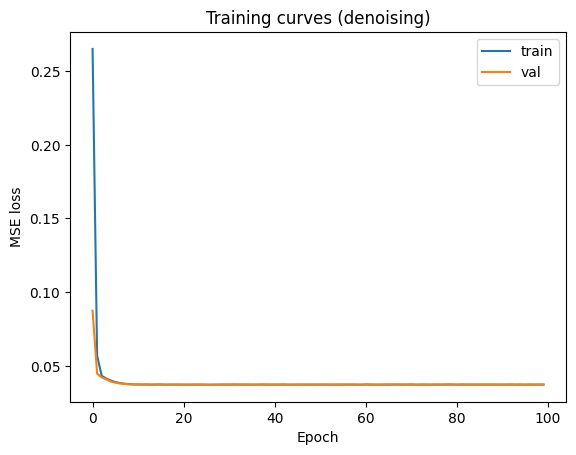

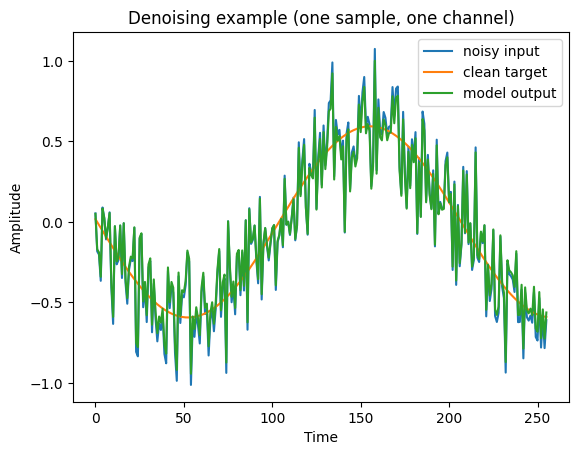

In [35]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 100
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "diagonal"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank: int =1
    
%timeit
train_demo()

In [36]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 25
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "RNN"
    implementation:str = "fast"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank: int =1
    
%timeit
train_demo()

Starting training...


/home/moritz/Documents/Hobby/State_space_models/mamba.py:351: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:307.)
  Q = self.Q


TypeError: '>' not supported between instances of 'builtin_function_or_method' and 'int'

Starting training...
Epoch 01/25  train 0.0402  val 0.0360
Epoch 02/25  train 0.0334  val 0.0311
Epoch 03/25  train 0.0295  val 0.0280
Epoch 04/25  train 0.0267  val 0.0255
Epoch 05/25  train 0.0241  val 0.0229
Epoch 06/25  train 0.0218  val 0.0207
Epoch 07/25  train 0.0197  val 0.0189
Epoch 08/25  train 0.0181  val 0.0176
Epoch 09/25  train 0.0170  val 0.0167
Epoch 10/25  train 0.0163  val 0.0161
Epoch 11/25  train 0.0158  val 0.0157
Epoch 12/25  train 0.0154  val 0.0153
Epoch 13/25  train 0.0152  val 0.0151
Epoch 14/25  train 0.0150  val 0.0150
Epoch 15/25  train 0.0148  val 0.0149
Epoch 16/25  train 0.0148  val 0.0147
Epoch 17/25  train 0.0147  val 0.0146
Epoch 18/25  train 0.0146  val 0.0146
Epoch 19/25  train 0.0145  val 0.0145
Epoch 20/25  train 0.0145  val 0.0145
Epoch 21/25  train 0.0144  val 0.0144
Epoch 22/25  train 0.0144  val 0.0144
Epoch 23/25  train 0.0144  val 0.0144
Epoch 24/25  train 0.0143  val 0.0144
Epoch 25/25  train 0.0143  val 0.0143
Done in 71.9s. Best val 0.014

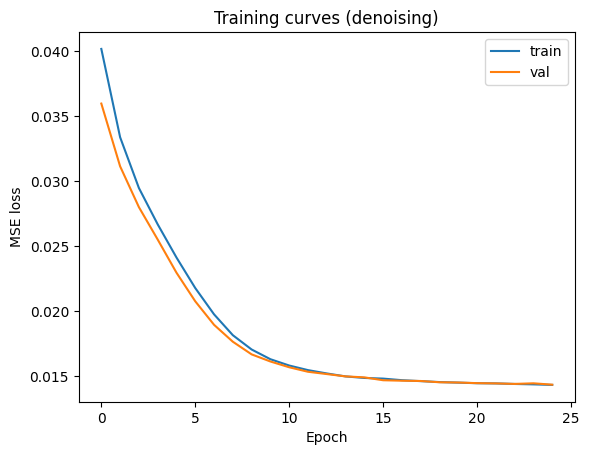

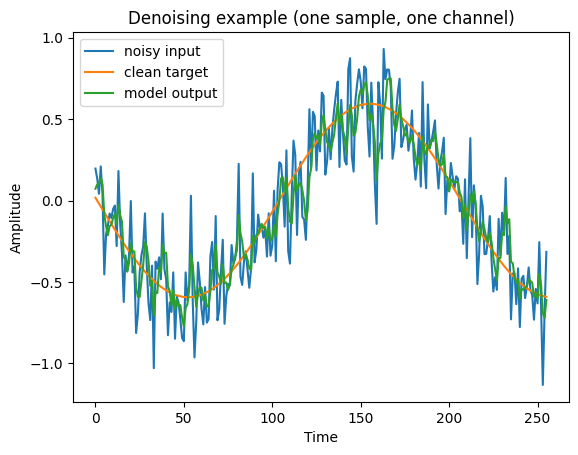

In [70]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 25
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "fast"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank: int =1
    
%timeit
train_demo()

Starting training...
Epoch 01/100  train 0.0402  val 0.0360
Epoch 02/100  train 0.0334  val 0.0311
Epoch 03/100  train 0.0295  val 0.0280
Epoch 04/100  train 0.0267  val 0.0255
Epoch 05/100  train 0.0241  val 0.0229
Epoch 06/100  train 0.0218  val 0.0207
Epoch 07/100  train 0.0197  val 0.0189
Epoch 08/100  train 0.0181  val 0.0176
Epoch 09/100  train 0.0170  val 0.0167
Epoch 10/100  train 0.0163  val 0.0161
Epoch 11/100  train 0.0158  val 0.0157
Epoch 12/100  train 0.0154  val 0.0153
Epoch 13/100  train 0.0152  val 0.0151
Epoch 14/100  train 0.0150  val 0.0150
Epoch 15/100  train 0.0148  val 0.0149
Epoch 16/100  train 0.0148  val 0.0147
Epoch 17/100  train 0.0147  val 0.0146
Epoch 18/100  train 0.0146  val 0.0146
Epoch 19/100  train 0.0145  val 0.0145
Epoch 20/100  train 0.0145  val 0.0145
Epoch 21/100  train 0.0144  val 0.0144
Epoch 22/100  train 0.0144  val 0.0144
Epoch 23/100  train 0.0144  val 0.0144
Epoch 24/100  train 0.0143  val 0.0144
Epoch 25/100  train 0.0143  val 0.0143
Epoc

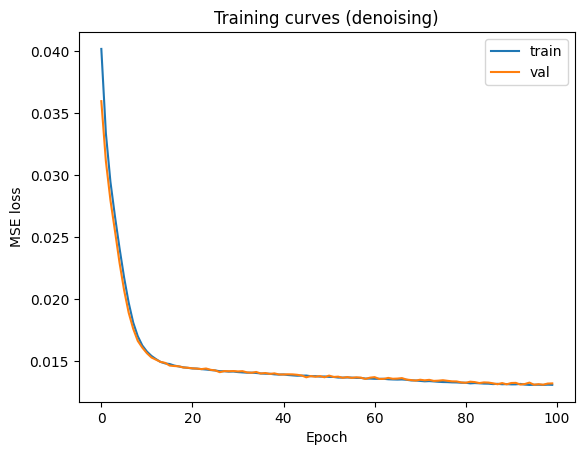

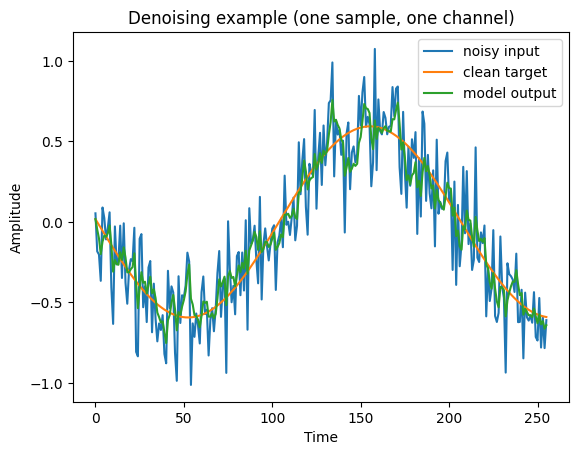

In [74]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 100
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "fast"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank:int =1
    
%timeit
train_demo()

Starting training...
Epoch 01/100  train 0.0432  val 0.0365
Epoch 02/100  train 0.0325  val 0.0286
Epoch 03/100  train 0.0253  val 0.0222
Epoch 04/100  train 0.0198  val 0.0178
Epoch 05/100  train 0.0165  val 0.0155
Epoch 06/100  train 0.0148  val 0.0144
Epoch 07/100  train 0.0141  val 0.0140
Epoch 08/100  train 0.0137  val 0.0136
Epoch 09/100  train 0.0135  val 0.0135
Epoch 10/100  train 0.0134  val 0.0134
Epoch 11/100  train 0.0133  val 0.0133
Epoch 12/100  train 0.0133  val 0.0133
Epoch 13/100  train 0.0132  val 0.0133
Epoch 14/100  train 0.0132  val 0.0132
Epoch 15/100  train 0.0131  val 0.0132
Epoch 16/100  train 0.0131  val 0.0131
Epoch 17/100  train 0.0131  val 0.0131
Epoch 18/100  train 0.0131  val 0.0132
Epoch 19/100  train 0.0130  val 0.0131
Epoch 20/100  train 0.0130  val 0.0131
Epoch 21/100  train 0.0130  val 0.0130
Epoch 22/100  train 0.0130  val 0.0130
Epoch 23/100  train 0.0130  val 0.0131
Epoch 24/100  train 0.0130  val 0.0131
Epoch 25/100  train 0.0130  val 0.0130
Epoc

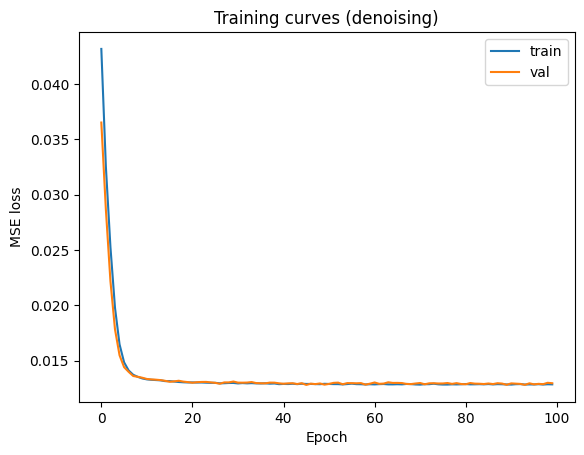

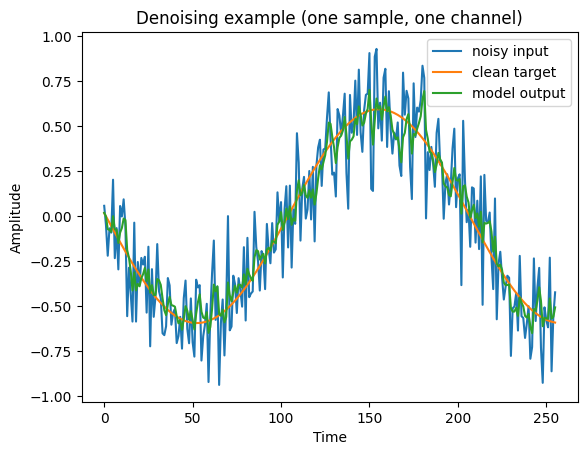

In [71]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 100
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "naive"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank=2
    
%timeit
train_demo()

Starting training...
Epoch 01/10  train 0.0380  val 0.0351
Epoch 02/10  train 0.0333  val 0.0317
Epoch 03/10  train 0.0299  val 0.0283
Epoch 04/10  train 0.0266  val 0.0251
Epoch 05/10  train 0.0234  val 0.0220
Epoch 06/10  train 0.0206  val 0.0194
Epoch 07/10  train 0.0184  val 0.0176
Epoch 08/10  train 0.0170  val 0.0166
Epoch 09/10  train 0.0162  val 0.0160
Epoch 10/10  train 0.0157  val 0.0156
Done in 35.8s. Best val 0.0156


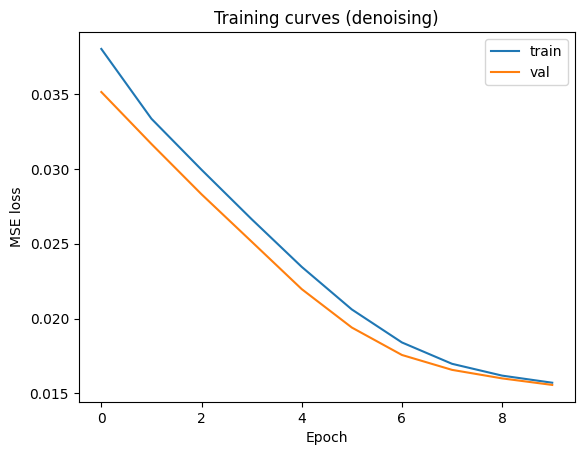

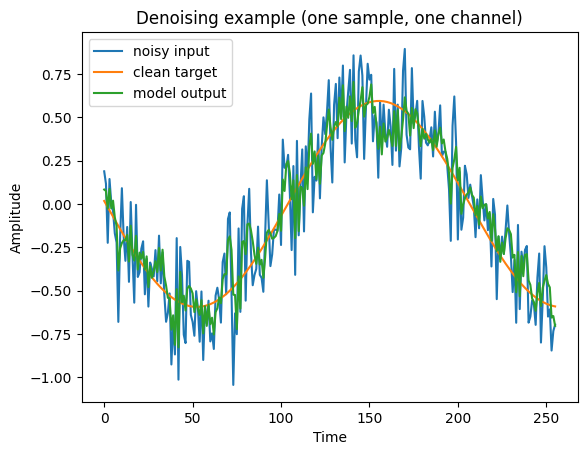

In [21]:
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64
    L: int = 256
    epochs: int = 10
    batch_size: int = 64
    lr: float = 1e-3
    mode: str = "CNN_fft"
    implementation:str = "fast"
    use_hippo: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    rank=2
    
%timeit
train_demo()

## Mamba

In [133]:
D=4
L=64
B=10
N=16
dcfg = DataCfg(D=D, L=L)
train_ds = SineDenoise(dcfg, "train", seed=0)
val_ds = SineDenoise(dcfg, "val", seed=1)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=B, shuffle=False)

In [129]:
#Train/eval
@dataclass
class TrainCfg:
    n_channels: int = 4
    N: int = 64 #paper 265
    L: int = 256
    epochs: int = 100
    batch_size: int = 64
    lr: float = 1e-3
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 123
    MLP_D : int = 248
    dropout:float = 0.2

def train_demo():
    # Seeds
    torch.manual_seed(TrainCfg.seed)

    # Data
    dcfg = DataCfg(D=TrainCfg.n_channels, L=TrainCfg.L)
    train_ds = SineDenoise(dcfg, "train", seed=0)
    val_ds = SineDenoise(dcfg, "val", seed=1)
    train_loader = DataLoader(train_ds, batch_size=TrainCfg.batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=TrainCfg.batch_size, shuffle=False)

    # Model
    model = Mamba(
        n_layers=1,
        d_model=TrainCfg.n_channels,
        d_state=TrainCfg.N,
        ffn_multiplier=TrainCfg.MLP_D,
        dropout = TrainCfg.dropout
    ).to(TrainCfg.device)

    opt = torch.optim.Adam(model.parameters(), lr=TrainCfg.lr)
    best_val = float("inf")
    train_losses, val_losses = [], []

    def run_loader(loader, train: bool):
        tot, n = 0.0, 0
        if train:
            model.train()
        else:
            model.eval()
        for noisy, clean in loader:
            noisy = noisy.to(TrainCfg.device)   # (B,D,L)
            clean = clean.to(TrainCfg.device)   # (B,D,L)
            if train:
                opt.zero_grad(set_to_none=True)
            pred = model(noisy)                 # (B,D,L)
            loss = nn.functional.mse_loss(pred, clean)
            if train:
                loss.backward()
                opt.step()
            tot += loss.item() * noisy.size(0)
            n += noisy.size(0)
        return tot / max(n, 1)

    print("Starting training...")
    t0 = time.time()
    for epoch in range(1, TrainCfg.epochs + 1):
        tr = run_loader(train_loader, train=True)
        va = run_loader(val_loader, train=False)
        train_losses.append(tr)
        val_losses.append(va)
        if va < best_val:
            best_val = va
            torch.save(
                {"model_state": model.state_dict(), "cfg": (TrainCfg, DataCfg)},
                "./models/Mamba/s6_demo.pt",
            )
        print(f"Epoch {epoch:02d}/{TrainCfg.epochs}  train {tr:.4f}  val {va:.4f}")
    print(f"Done in {time.time()-t0:.1f}s. Best val {best_val:.4f}")

    # ---- Visualization
    # Loss curves
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training curves (denoising)")
    plt.legend()
    plt.show()

    # Qualitative predictions on a random validation batch & a single channel
    model.eval()
    with torch.no_grad():
        noisy, clean = next(iter(val_loader))
        noisy = noisy.to(TrainCfg.device)
        clean = clean.to(TrainCfg.device)
        pred = model(noisy)

    b = 0               # first sample in batch
    d = 0               # channel 0
    x = noisy[b, d].detach().cpu()
    y = clean[b, d].detach().cpu()
    yhat = pred[b, d].detach().cpu()

    plt.figure()
    plt.plot(x, label="noisy input")
    plt.plot(y, label="clean target")
    plt.plot(yhat, label="model output")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Denoising example (one sample, one channel)")
    plt.legend()
    plt.show()


In [ ]:
train

In [ ]:
model = Mamba(
        n_layers=1,
        d_model=D,
        d_state=N,
        ffn_multiplier=4,
        dropout = 0
)
model(train_loader.__iter__().next()[0])

AttributeError: 'SineDenoise' object has no attribute '__iter__'

In [132]:
train_demo()

Starting training...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x256 and 4x64)